In [58]:
import torch
import random
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import combinations
from transformers import AutoTokenizer, AutoModel
from catboost import CatBoostRegressor, Pool
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import  mean_absolute_error
from sklearn.utils import resample
from torch_geometric.data import HeteroData
from torch_geometric.nn import to_hetero, GATConv, Linear, MetaPath2Vec
from torch_geometric import transforms

# Data preprocessing

In [2]:
books_data = pd.read_csv("books_data.csv")
books_data.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


In [3]:
books_data.drop(["image", "previewLink", "infoLink", "ratingsCount"], axis=1, inplace=True)

In [4]:
books_rating = pd.read_csv("books_rating.csv")
books_rating.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [5]:
books_rating.drop(["Id", "Price", "User_id", "review/time", "review/summary"], axis=1, inplace=True)

In [6]:
data_df = books_rating.merge(books_data, on="Title", how="left")

In [7]:
data_df.dropna(inplace=True)

In [8]:
data_df.nunique()

Title                  117816
profileName            661217
review/helpfulness       9697
review/score                5
review/text           1240370
description            109417
authors                 84776
publisher               12221
publishedDate           10476
categories               3396
dtype: int64

In [9]:
data_df["authors"] = data_df["authors"].apply(lambda x: eval(x))
data_df["category"] = data_df["categories"].apply(lambda x: eval(x)[0])
data_df["year"] = data_df["publishedDate"].apply(lambda x: int(x.split("-")[0].replace("?", "0")))
data_df["helpfulness_score"] = data_df["review/helpfulness"].apply(lambda x: int(x.split("/")[0]) / int(x.split("/")[1]) if int(x.split("/")[1]) != 0 else 0.0)
data_df["helpfulness_count"] = data_df["review/helpfulness"].apply(lambda x: int(x.split("/")[1]))

data_df.drop(["review/helpfulness", "publishedDate", "categories"], axis=1, inplace=True)

data_df.rename(columns={"Title": "book", 
                        "profileName": "user", 
                        "review/text": "review_text", 
                        "description": "book_text", 
                        "publishedDate": "date",
                        "categories": "category",
                        "review/score": "target"}, inplace=True)

In [10]:
G = nx.Graph()

for _, row in data_df.iterrows():
    user = row['user']
    G.add_node(user, bipartite=1)
    authors = row['authors']
    for author in authors:
        G.add_node(author, bipartite=0)
        G.add_edge(user, author)

In [11]:
def expand_bipartite_graph(G, k, d, n, random_seed=None):
    if random_seed is not None:
        random.seed(random_seed)

    authors = [node for node in G.nodes if G.nodes[node]['bipartite'] == 0]
    users = [node for node in G.nodes if G.nodes[node]['bipartite'] == 1]

    initial_authors = set(random.sample(authors, min(k, len(authors))))
    initial_users = set(random.sample(users, min(k, len(users))))

    selected_authors = set(initial_authors)
    selected_users = set(initial_users)

    for _ in range(n):
        new_authors = {node for node in G.nodes if node not in selected_authors
                       and G.nodes[node]['bipartite'] == 0
                       and sum(1 for neighbor in G.neighbors(node) if neighbor in selected_users) >= d}

        new_users = {node for node in G.nodes if node not in selected_users
                     and G.nodes[node]['bipartite'] == 1
                     and sum(1 for neighbor in G.neighbors(node) if neighbor in selected_authors) >= d}

        selected_authors.update(new_authors)
        selected_users.update(new_users)

    return selected_authors, selected_users

In [12]:
k = 200 
d = 8
n = 2

selected_authors, selected_users = expand_bipartite_graph(G, k, d, n)

data_df = data_df[data_df["user"].isin(selected_users) | data_df["authors"].apply(lambda authors: any(author in selected_authors for author in authors))]
data_df.reset_index(drop=True, inplace=True)

In [13]:
train_mask = np.random.rand(len(data_df)) < 0.8
test_mask = ~train_mask

In [14]:
def get_text_embeddings(texts, batch_size=32, emb_dim=None):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {key: val.to(device) for key, val in inputs.items()}  # Переносим тензоры на устройство

        with torch.no_grad():
            outputs = embeddings_model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Переносим результат на CPU
        embeddings.append(batch_embeddings)

    embeddings = np.vstack(embeddings)
    
    if emb_dim is not None:
        pca = PCA(n_components=emb_dim)
        embeddings = pca.fit_transform(embeddings)

    return embeddings

In [15]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
embeddings_model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embeddings_model = embeddings_model.to(device)

data_df['review_embedding'] = list(get_text_embeddings(data_df['review_text'].tolist(), emb_dim=8))
data_df['book_embedding'] = list(get_text_embeddings(data_df['book_text'].tolist(), emb_dim=8))

/home/dmitry_malikov/miniconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# EDA

In [19]:
def create_graph(data_df, similarity_threshold=0.8):
    reviews_df = data_df[['user', 'book', 'review_text', 'helpfulness_score', 'helpfulness_count', 'target']].copy()
    books_df = data_df[['book', 'book_text', 'authors', 'publisher', 'category', 'year']].drop_duplicates(subset='book').copy().reset_index(drop=True)

    G = nx.Graph()

    for i, row in reviews_df.iterrows():
        review_id = f"review_{i}"
        book_id = f"book_{row['book']}"
        user_id = f"user_{row['user']}"

        G.add_node(review_id, type="review")
        G.add_node(book_id, type="book")
        G.add_node(user_id, type="user")
            
        G.add_edge(review_id, user_id, connection="review_to_user")
        G.add_edge(review_id, book_id, connection="review_to_book")

    for i, row in books_df.iterrows():
        book_id = f"book_{row['book']}"
        category_id = f"category_{row['category']}"
        publisher_id = f"publisher_{row['publisher']}"
        author_ids = [f"author_{author}" for author in row["authors"]]

        G.add_node(category_id, type="category")
        G.add_node(publisher_id, type="publisher")
        for author_id in author_ids:
            G.add_node(author_id, type="author")
            
        G.add_edge(book_id, category_id, connection="book_to_category")
        G.add_edge(book_id, publisher_id, connection="book_to_publisher")
        for author_id in author_ids:
            G.add_edge(book_id, author_id, connection="book_to_author")

    review_embeddings = get_text_embeddings(reviews_df["review_text"].tolist())
    review_similarity = cosine_similarity(review_embeddings)
    mask = review_similarity > similarity_threshold
    np.fill_diagonal(mask, False)
    row, col = np.where(mask)
    edges = {(min(i, j), max(i, j)) for i, j in zip(row, col)}
    for i, j in edges:
        G.add_edge(f"review_{i}", f"review_{j}", connection="review_similarity")

    book_embeddings = get_text_embeddings(books_df["book_text"].tolist())
    book_similarity = cosine_similarity(book_embeddings)
    mask = book_similarity > similarity_threshold
    np.fill_diagonal(mask, False)
    row, col = np.where(mask)
    edges = {(min(i, j), max(i, j)) for i, j in zip(row, col)}
    for i, j in edges:
        G.add_edge(f"book_{books_df['book'][i]}", f"book_{books_df['book'][j]}", connection="book_similarity")

    return G

In [20]:
G = create_graph(data_df)

In [21]:
print("Number of nodes:", len(G.nodes))
print("Number of edges:", len(G.edges))

Number of nodes: 6202
Number of edges: 325554


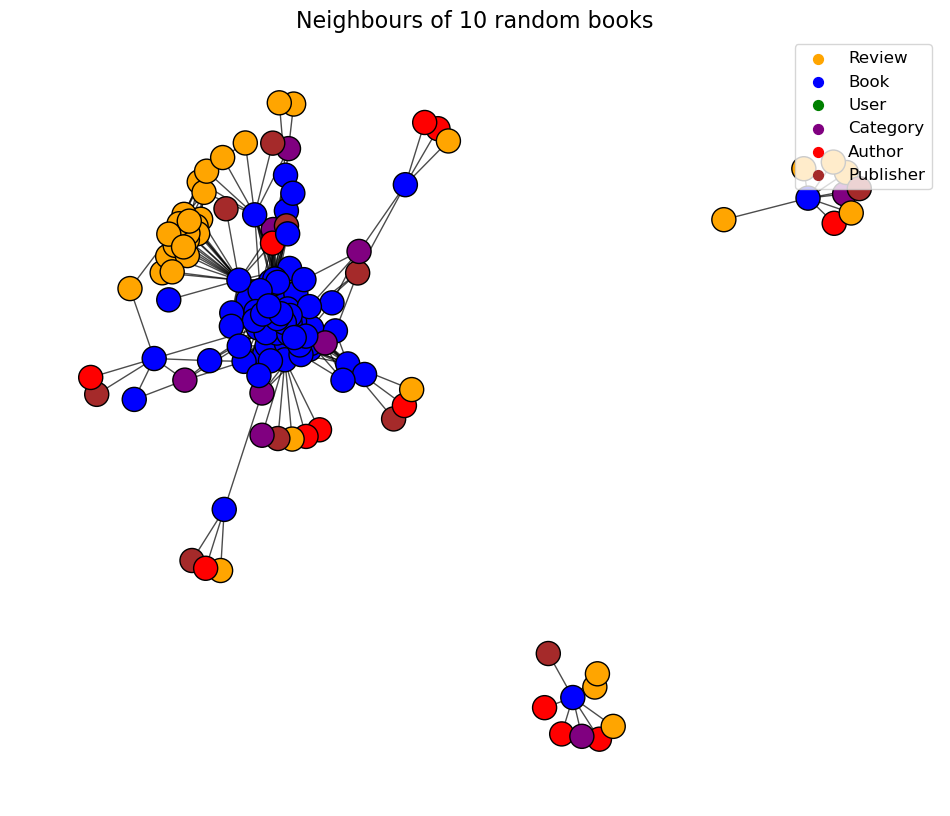

In [22]:
book_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == "book"]
selected_nodes = random.sample(book_nodes, min(10, len(book_nodes)))

subgraph_nodes = set(selected_nodes)
for node in selected_nodes:
    subgraph_nodes.update(G.neighbors(node))

subgraph = G.subgraph(subgraph_nodes)

pos = nx.spring_layout(subgraph)  
plt.figure(figsize=(12, 10))

node_colors = {
    "review": "orange",
    "book": "blue",
    "user": "green",
    "category": "purple",
    "author": "red",
    "publisher": "brown",
}
node_color_map = [node_colors[subgraph.nodes[n]["type"]] for n in subgraph.nodes]

nx.draw_networkx_nodes(subgraph, pos, node_color=node_color_map, edgecolors="black", node_size=300)

nx.draw_networkx_edges(subgraph, pos, alpha=0.7)

legend_labels = {
    "review": "Review",
    "book": "Book",
    "user": "User",
    "category": "Category",
    "author": "Author",
    "publisher": "Publisher",
}
for node_type, color in node_colors.items():
    plt.scatter([], [], color=color, label=legend_labels[node_type], s=50)

plt.legend(scatterpoints=1, frameon=True, loc="upper right", fontsize=12)

plt.title("Neighbours of 10 random books", fontsize=16)
plt.axis("off")
plt.show()

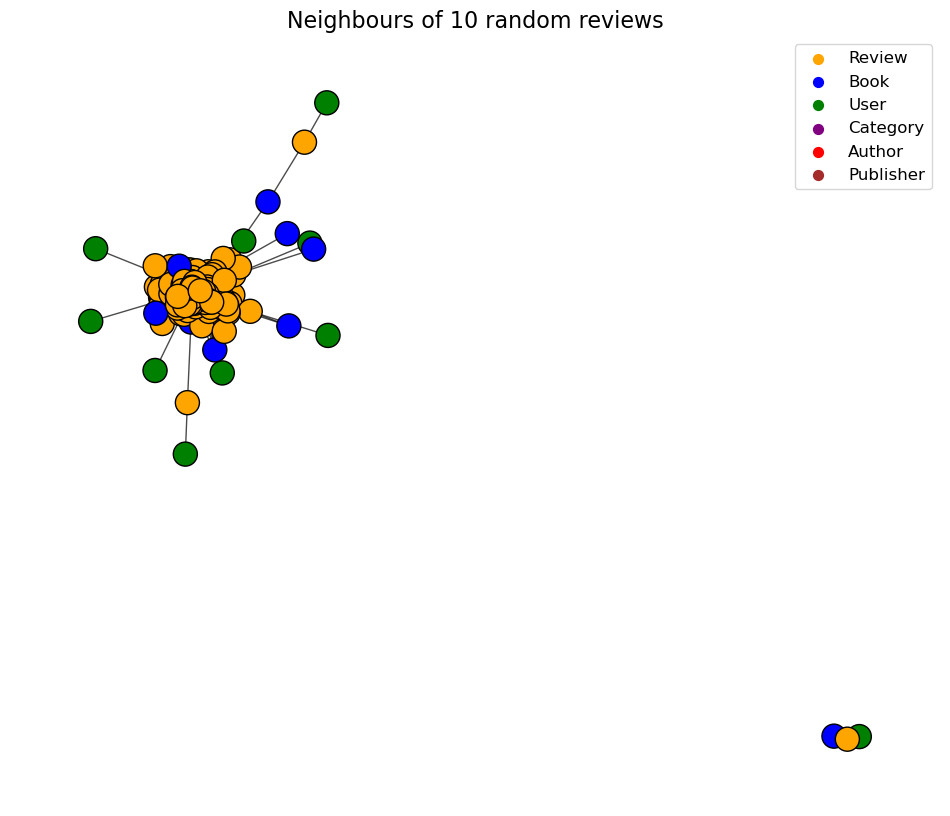

In [23]:
rewiew_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == "review"]
selected_nodes = random.sample(rewiew_nodes, min(10, len(rewiew_nodes)))

subgraph_nodes = set(selected_nodes)
for node in selected_nodes:
    subgraph_nodes.update(G.neighbors(node))

subgraph = G.subgraph(subgraph_nodes)

pos = nx.spring_layout(subgraph)  
plt.figure(figsize=(12, 10))

node_colors = {
    "review": "orange",
    "book": "blue",
    "user": "green",
    "category": "purple",
    "author": "red",
    "publisher": "brown",
}
node_color_map = [node_colors[subgraph.nodes[n]["type"]] for n in subgraph.nodes]

nx.draw_networkx_nodes(subgraph, pos, node_color=node_color_map, edgecolors="black", node_size=300)

nx.draw_networkx_edges(subgraph, pos, alpha=0.7)

legend_labels = {
    "review": "Review",
    "book": "Book",
    "user": "User",
    "category": "Category",
    "author": "Author",
    "publisher": "Publisher",
}
for node_type, color in node_colors.items():
    plt.scatter([], [], color=color, label=legend_labels[node_type], s=50)

plt.legend(scatterpoints=1, frameon=True, loc="upper right", fontsize=12)

plt.title("Neighbours of 10 random reviews", fontsize=16)
plt.axis("off")
plt.show()

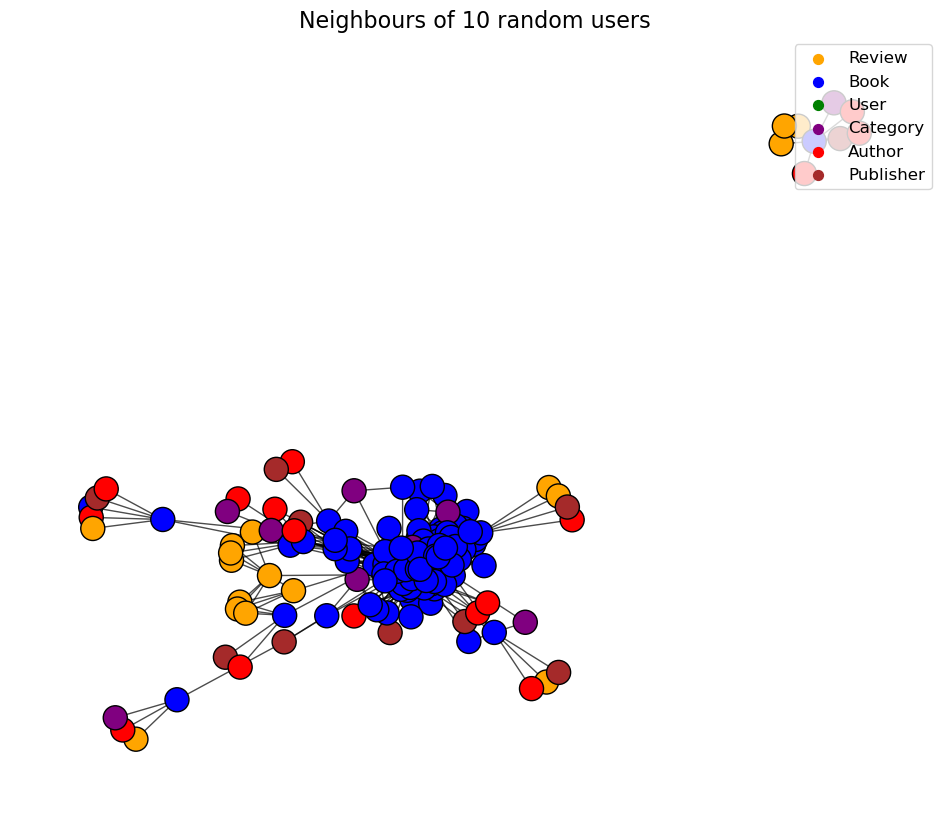

In [24]:
user_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == "user"]
selected_nodes = random.sample(book_nodes, min(10, len(user_nodes)))

subgraph_nodes = set(selected_nodes)
for node in selected_nodes:
    subgraph_nodes.update(G.neighbors(node))

subgraph = G.subgraph(subgraph_nodes)

pos = nx.spring_layout(subgraph)  
plt.figure(figsize=(12, 10))

node_colors = {
    "review": "orange",
    "book": "blue",
    "user": "green",
    "category": "purple",
    "author": "red",
    "publisher": "brown",
}
node_color_map = [node_colors[subgraph.nodes[n]["type"]] for n in subgraph.nodes]

nx.draw_networkx_nodes(subgraph, pos, node_color=node_color_map, edgecolors="black", node_size=300)

nx.draw_networkx_edges(subgraph, pos, alpha=0.7)

legend_labels = {
    "review": "Review",
    "book": "Book",
    "user": "User",
    "category": "Category",
    "author": "Author",
    "publisher": "Publisher",
}
for node_type, color in node_colors.items():
    plt.scatter([], [], color=color, label=legend_labels[node_type], s=50)

plt.legend(scatterpoints=1, frameon=True, loc="upper right", fontsize=12)

plt.title("Neighbours of 10 random users", fontsize=16)
plt.axis("off")
plt.show()

/home/dmitry_malikov/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


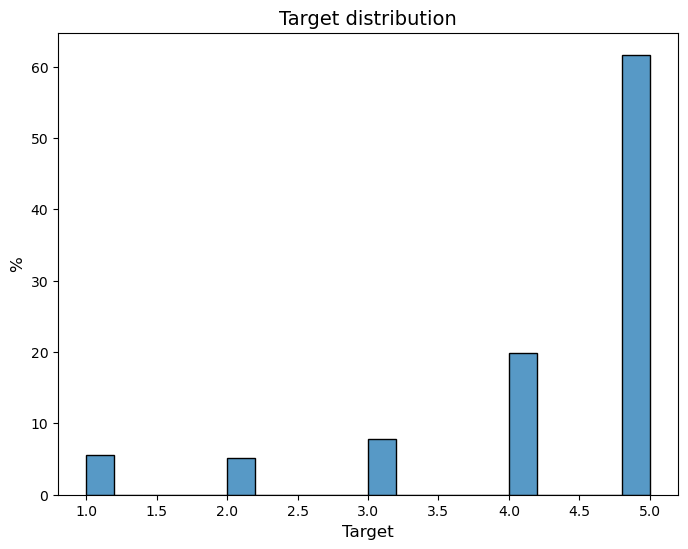

In [25]:
plt.figure(figsize=(8, 6))
sns.histplot(x=data_df["target"].astype(int), bins=20, stat="percent")
plt.title("Target distribution", fontsize=14)
plt.xlabel("Target", fontsize=12)
plt.ylabel("%", fontsize=12)
plt.show()

In [26]:
density = nx.density(G)

if nx.is_connected(G):
    diameter = nx.diameter(G)
else:
    diameter = None

print(density, diameter)

0.01693010057931903 None


In [27]:
def get_top_degree_centrality(graph, data_df, column,  top_n=3):
    degree_centrality = nx.degree_centrality(graph)

    degree_centrality = dict((k, v) for k, v in degree_centrality.items() if k.startswith("review_"))
    
    sorted_nodes = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)

    top_nodes = sorted_nodes[:top_n]
    
    top_texts = []
    for node, _ in top_nodes:
        node = int(node[7:])
        top_texts.append(data_df.loc[node, column])
    
    return top_nodes, top_texts

top_nodes_reviews, top_texts_reviews = get_top_degree_centrality(G, data_df, "review_text", top_n=3)

print("\nTop 3 nodes for G_reviews (Degree Centrality):")
for i, (node, centrality) in enumerate(top_nodes_reviews):
    print(f"{i+1}. Degree Centrality: {centrality}\nReview Text: {top_texts_reviews[i]}\n")


Top 3 nodes for G_reviews (Degree Centrality):
1. Degree Centrality: 0.18980809546847283
Review Text: I'm the type of reader that has to get hooked within the first ten pages, or forget it. I picked up this book in the airport as a &quot;time-killer&quot;, but found myself turning page after page. Cynthia Hartwick's writing is superb! I read this book in two days and lent it to a girlfriend. Definitely get it!!

2. Degree Centrality: 0.18658280922431866
Review Text: Without knowing anything about this book I picked it up and read it in a day. Great plot, wonderful characters, it kept me happily turning page after page and I was saddened to see it end.I'm planning to buy multiple copies to give as gifts and am quite sure that I'll read it again and again.

3. Degree Centrality: 0.18480890179003387
Review Text: Always guaranteed to be a good read if the Author is Vicki Lewis Thompson and you wont be disappointed here either.I would and will always recommend Ms. Thompson's books to anyon

# Classic models

In [28]:
X_categorical = data_df[['book', 'user', 'authors', 'publisher', 'category']]
X_categorical.loc[:, "authors"] = X_categorical["authors"].apply(str)
X_numerical = data_df[['year', 'helpfulness_score', 'helpfulness_count']]
X_embeddings = pd.concat([
    pd.DataFrame(data_df.loc[data_df.index, 'review_embedding'].tolist(), index=data_df.index, columns=map(lambda x: f"Review embedding {x}", range(8))),
    pd.DataFrame(data_df.loc[data_df.index, 'book_embedding'].tolist(), index=data_df.index, columns=map(lambda x: f"Book embedding {x}", range(8)))
], axis=1)


y_train = data_df['target'][train_mask].astype(int)
y_test = data_df['target'][test_mask].astype(int)

## Linear regression

In [29]:
encoder = TargetEncoder()
X_encoded_train = pd.DataFrame(encoder.fit_transform(X_categorical[train_mask], y_train), index=y_train.index)
X_encoded_test = pd.DataFrame(encoder.transform(X_categorical[test_mask]), index=y_test.index)


X_train = pd.concat([X_encoded_train, X_numerical[train_mask], X_embeddings[train_mask]], axis=1)
X_test = pd.concat([X_encoded_test, X_numerical[test_mask], X_embeddings[test_mask]], axis=1)

X_train.columns = map(str, X_train.columns)
X_test.columns = map(str, X_test.columns)

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

y_pred = np.round(np.clip(linreg.predict(X_test_scaled), 1, 5))

mae = mean_absolute_error(y_test, y_pred)
print(f"Linear Regression MAE: {mae:.3f}")

Linear Regression MAE: 0.675


## CatBoost

In [31]:
X_train = pd.concat([X_categorical[train_mask], X_numerical[train_mask], X_embeddings[train_mask]], axis=1)
X_test = pd.concat([X_categorical[test_mask], X_numerical[test_mask], X_embeddings[test_mask]], axis=1)

In [32]:
cat_features = ['book', 'user', 'authors', 'publisher', 'category']
catboost = CatBoostRegressor(iterations=200, verbose=True)

train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

catboost.fit(train_pool, verbose=False, eval_set=test_pool)
y_pred_catboost = y_pred = np.round(np.clip(catboost.predict(X_test), 1, 5))

mae = mean_absolute_error(y_test, y_pred)
print(f"CatBoost MAE: {mae:.3f}")

CatBoost MAE: 0.551


# Graph algorithms

In [33]:
def create_graph_data(data_df, node_embeddings=None, similarity_threshold=0.8):
    reviews_df = data_df[['user', 'book', 'review_text', 'helpfulness_score', 'helpfulness_count', 'target']].copy()
    books_df = data_df[['book', 'book_text', 'authors', 'publisher', 'category', 'year']].drop_duplicates(subset='book').copy().reset_index(drop=True)
    
    data = HeteroData()

    review_embeddings = torch.tensor(get_text_embeddings(reviews_df["review_text"].tolist()))
    review_similarity = cosine_similarity(review_embeddings)

    book_embeddings = torch.tensor(get_text_embeddings(books_df["book_text"].tolist()))
    book_similarity = cosine_similarity(book_embeddings)
    

    review_ids = range(len(reviews_df))
    data['review'].x = node_embeddings['review'] if node_embeddings else review_embeddings
    data['review'].y = torch.tensor([int(score) - 1 for score in reviews_df['target']], dtype=torch.long) 
    data['review'].train_mask = train_mask
    data['review'].test_mask = test_mask

    user_ids = reviews_df['user'].unique().tolist()
    data['user'].x = node_embeddings['user'] if node_embeddings else torch.eye(len(user_ids))

    book_ids = books_df['book'].unique().tolist()
    data['book'].x = node_embeddings['book'] if node_embeddings else book_embeddings

    category_ids = books_df['category'].unique().tolist()
    data['category'].x = node_embeddings['category'] if node_embeddings else torch.eye(len(category_ids))

    publisher_ids = books_df['publisher'].unique().tolist()
    data['publisher'].x = node_embeddings['publisher'] if node_embeddings else torch.eye(len(publisher_ids))

    author_ids = list(set(author for authors in books_df["authors"] for author in authors))
    data['author'].x = node_embeddings['author'] if node_embeddings else torch.eye(len(author_ids))
    

    review_to_user_edges = []
    for i in range(len(reviews_df)):
        user = reviews_df.loc[i, 'user']
        review_to_user_edges += [(i, user_ids.index(user))]
    review_to_user_edges = torch.tensor(review_to_user_edges).t()
    data['review', 'to', 'user'].edge_index = review_to_user_edges

    review_to_book_edges = []
    for i in range(len(reviews_df)):
        book = reviews_df.loc[i, 'book']
        review_to_book_edges += [(i, book_ids.index(book))]
    review_to_book_edges = torch.tensor(review_to_book_edges).t()
    data['review', 'to', 'book'].edge_index = review_to_book_edges

    book_to_category_edges = []
    for i in range(len(books_df)):
        book = books_df.loc[i, 'book']
        category = books_df.loc[i, 'category']
        book_to_category_edges += [(book_ids.index(book), category_ids.index(category))]
    book_to_category_edges = torch.tensor(book_to_category_edges).t()
    data['book', 'to', 'category'].edge_index = book_to_category_edges

    book_to_publisher_edges = []
    for i in range(len(books_df)):
        book = books_df.loc[i, 'book']
        publisher = books_df.loc[i, 'publisher']
        book_to_publisher_edges += [(book_ids.index(book), publisher_ids.index(publisher))]
    book_to_publisher_edges = torch.tensor(book_to_publisher_edges).t()
    data['book', 'to', 'publisher'].edge_index = book_to_publisher_edges

    book_to_author_edges = []
    for i in range(len(books_df)):
        book = books_df.loc[i, 'book']
        for author in books_df.loc[i, 'authors']:
            book_to_author_edges += [(book_ids.index(book), author_ids.index(author))]
    book_to_author_edges = torch.tensor(book_to_author_edges).t()
    data['book', 'to', 'author'].edge_index = book_to_author_edges


    mask = review_similarity > similarity_threshold
    np.fill_diagonal(mask, False)
    row, col = np.where(mask)
    review_to_review_edges = list({(min(i, j), max(i, j)) for i, j in zip(row, col)})
    review_to_review_edges = torch.tensor(review_to_review_edges).t()
    data['review', 'to', 'review'].edge_index = review_to_review_edges

    mask = book_similarity > similarity_threshold
    np.fill_diagonal(mask, False)
    row, col = np.where(mask)
    book_to_book_edges = list({(min(i, j), max(i, j)) for i, j in zip(row, col)})
    book_to_book_edges = torch.tensor(book_to_book_edges).t()
    data['book', 'to', 'book'].edge_index = book_to_book_edges

    data = transforms.ToUndirected()(data)

    return data

In [34]:
data = create_graph_data(data_df)

## Network embeddings

In [35]:
data.metadata()[1]

[('review', 'to', 'user'),
 ('review', 'to', 'book'),
 ('book', 'to', 'category'),
 ('book', 'to', 'publisher'),
 ('book', 'to', 'author'),
 ('review', 'to', 'review'),
 ('book', 'to', 'book'),
 ('user', 'rev_to', 'review'),
 ('book', 'rev_to', 'review'),
 ('category', 'rev_to', 'book'),
 ('publisher', 'rev_to', 'book'),
 ('author', 'rev_to', 'book')]

In [36]:
metapaths = [
    ('review', 'to', 'user'),
    ('user', 'rev_to', 'review'),
    ('review', 'to', 'book'),
    ('book', 'to', 'category'),
    ('category', 'rev_to', 'book'),
    ('book', 'to', 'publisher'),
    ('publisher', 'rev_to', 'book'),
    ('book', 'to', 'author'),
    ('author', 'rev_to', 'book'),
    ('book', 'rev_to', 'review'),
]

In [37]:
def train(model, log_steps=100, eval_steps=2000):
    model.train()
    total_loss = 0
    for i, (pos_rw, neg_rw) in enumerate(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss

In [38]:
embedding_dim = 16
model = MetaPath2Vec(
    data.edge_index_dict,
    embedding_dim=embedding_dim,
    metapath=metapaths,
    walk_length=10,
    context_size=5,
    walks_per_node=10,
    num_negative_samples=5,
    sparse=True
).to(device)

loader = model.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.SparseAdam(model.parameters(), lr=0.01)

In [39]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    for epoch in range(50):
        loss = train(model)
        print(f"epoch: {epoch}, loss: {loss}")

epoch: 0, loss: 57.01611804962158
epoch: 1, loss: 46.29300284385681
epoch: 2, loss: 39.039689898490906
epoch: 3, loss: 33.95709705352783
epoch: 4, loss: 30.397193908691406
epoch: 5, loss: 27.676994800567627
epoch: 6, loss: 25.651923179626465
epoch: 7, loss: 23.99238407611847
epoch: 8, loss: 22.69284164905548
epoch: 9, loss: 21.625503659248352
epoch: 10, loss: 20.74886178970337
epoch: 11, loss: 20.061015605926514
epoch: 12, loss: 19.437444925308228
epoch: 13, loss: 18.921990871429443
epoch: 14, loss: 18.500845193862915
epoch: 15, loss: 18.14262717962265
epoch: 16, loss: 17.830708861351013
epoch: 17, loss: 17.551885843276978
epoch: 18, loss: 17.300687551498413
epoch: 19, loss: 17.077425718307495
epoch: 20, loss: 16.854808926582336
epoch: 21, loss: 16.664073824882507
epoch: 22, loss: 16.49202960729599
epoch: 23, loss: 16.29728490114212
epoch: 24, loss: 16.125548779964447
epoch: 25, loss: 15.951527416706085
epoch: 26, loss: 15.779902398586273
epoch: 27, loss: 15.587498247623444
epoch: 28, 

In [40]:
with torch.no_grad():
    node_embeddings = {key: model(key).detach().cpu() for key in ["review", "book", "user", "publisher", "author", "category"]}

### Network embeddings with classic models

In [49]:
X_node_embeddings_train = pd.DataFrame(node_embeddings["review"][train_mask], index=y_train.index)
X_node_embeddings_test = pd.DataFrame(node_embeddings["review"][test_mask], index=y_test.index)

In [50]:
encoder = TargetEncoder()

X_encoded_train = pd.DataFrame(encoder.fit_transform(X_categorical[train_mask], y_train), index=y_train.index)
X_encoded_test = pd.DataFrame(encoder.transform(X_categorical[test_mask]), index=y_test.index)

X_train = pd.concat([X_encoded_train, X_numerical[train_mask], X_embeddings[train_mask], X_node_embeddings_train], axis=1)
X_test = pd.concat([X_encoded_test, X_numerical[test_mask], X_embeddings[test_mask], X_node_embeddings_test], axis=1)

X_train.columns = map(str, X_train.columns)
X_test.columns = map(str, X_test.columns)

In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

y_pred = np.round(np.clip(linreg.predict(X_test_scaled), 1, 5))

mae = mean_absolute_error(y_test, y_pred)
print(f"Logistic Regression MAE: {mae:.3f}")

Logistic Regression MAE: 0.630


In [52]:
X_train = pd.concat([X_categorical[train_mask], X_numerical[train_mask], X_embeddings[train_mask], X_node_embeddings_train], axis=1)
X_test = pd.concat([X_categorical[test_mask], X_numerical[test_mask], X_embeddings[test_mask], X_node_embeddings_test], axis=1)

In [53]:
cat_features = ['book', 'user', 'authors', 'publisher', 'category']
catboost = CatBoostRegressor(iterations=100, verbose=True)

train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

catboost.fit(train_pool, verbose=False, eval_set=test_pool)
y_pred = np.round(np.clip(catboost.predict(X_test), 1, 5))

mae = mean_absolute_error(y_test, y_pred)
print(f"CatBoost MAE: {mae:.3f}")

CatBoost MAE: 0.510


## HGNN

In [62]:
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    pred = out["review"][data['review'].train_mask].squeeze()
    true = data['review'].y[data['review'].train_mask].to(torch.float32)
    loss = criterion(pred, true)
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x_dict, data.edge_index_dict)
        pred = torch.round(out["review"][data['review'].test_mask])
        true = data['review'].y[data['review'].test_mask]
        mae = mean_absolute_error(true, pred)
    return mae


In [63]:
class GATNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        self.lin1 = Linear(-1, hidden_channels)
        self.conv2 = GATConv((-1, -1), out_channels, add_self_loops=False)
        self.lin2 = Linear(-1, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index) + self.lin1(x)
        x = x.relu()
        x = self.conv2(x, edge_index) + self.lin2(x)
        x = torch.clamp(x, 0, 4)
        return x

In [64]:
model = GATNN(hidden_channels=128, out_channels=1)
model = to_hetero(model, data.metadata(), aggr='sum')

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()

with torch.no_grad():
    out = model(data.x_dict, data.edge_index_dict)

In [65]:
for i in range(20):
    loss = train(model, data, optimizer, criterion)
    mae = test(model, data)
    print(f"Epoch {i}: MAE = {mae:.4f}")

Epoch 0: MAE = 2.0659
Epoch 1: MAE = 1.2838
Epoch 2: MAE = 0.8350
Epoch 3: MAE = 0.6737
Epoch 4: MAE = 0.6040
Epoch 5: MAE = 0.5561
Epoch 6: MAE = 0.5256
Epoch 7: MAE = 0.5016
Epoch 8: MAE = 0.5038
Epoch 9: MAE = 0.5082
Epoch 10: MAE = 0.5082
Epoch 11: MAE = 0.5125
Epoch 12: MAE = 0.5147
Epoch 13: MAE = 0.5082
Epoch 14: MAE = 0.5060
Epoch 15: MAE = 0.4995
Epoch 16: MAE = 0.4995
Epoch 17: MAE = 0.4995
Epoch 18: MAE = 0.5016
Epoch 19: MAE = 0.5016


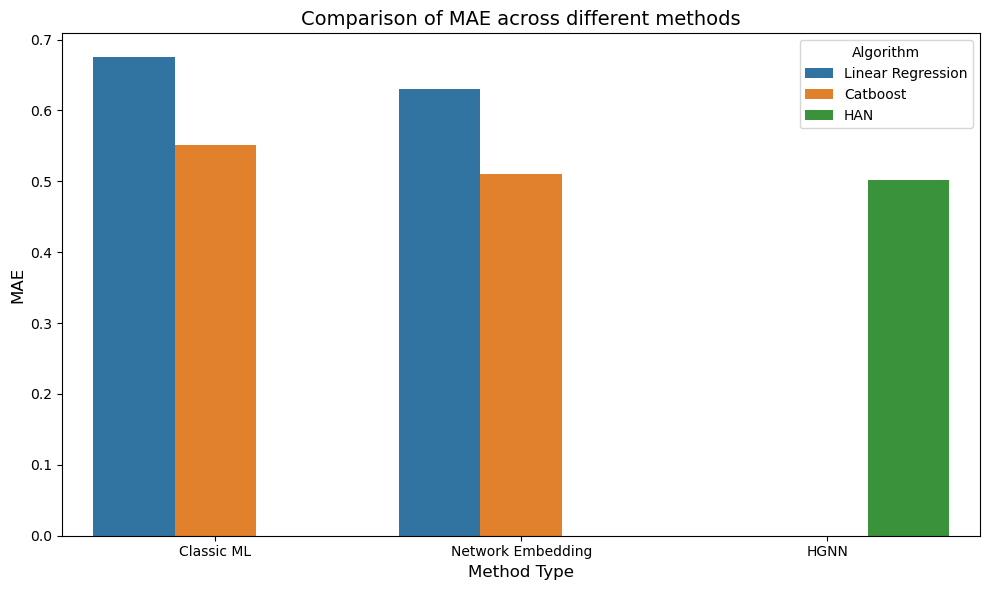

In [66]:
experimets = {
    "Method": ["Classic ML"] * 2 + ["Network Embedding"] * 2 + ["HGNN"],
    "Algorithm": ["Linear Regression", "Catboost", "Linear Regression", "Catboost", "HAN"],
    "MAE": [0.675, 0.551, 0.63, 0.51, 0.5016]
}

mae_df = pd.DataFrame(experimets)

plt.figure(figsize=(10, 6))
sns.barplot(data=mae_df, x="Method", y="MAE", hue="Algorithm")
plt.title("Comparison of MAE across different methods", fontsize=14)
plt.xlabel("Method Type", fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.legend(title="Algorithm", fontsize=10)
plt.tight_layout()
plt.show()